<a href="https://colab.research.google.com/github/WinetraubLab/coregister-xy/blob/main/coregister_xy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/WinetraubLab/coregister-xy/blob/main/coregister_xy.ipynb" target="_blank">
<img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>

<a href="https://github.com/WinetraubLab/coregister-xy/blob/main/coregister_xy.ipynb" target="_blank">
  <img src="https://img.shields.io/badge/view%20in-GitHub-blue" alt="View in GitHub"/>
</a>

# Overview
Use this notebook to align a fluorescent image to photobleach template.


In [1]:
# @title Notebook Inputs { display-mode: "form" }
# @markdown Input Image Paths:
# @markdown Leave either image path blank to load a file from local file system.
fluorescent_image_path = "/content/drive/Shareddrives/Yolab - Current Projects/_Datasets/2024-07-30 CoregisterXY Examples/example_fluorescent.tif" # @param {type:"string"}

# @markdown To obtain the template image file, run [this code](https://github.com/WinetraubLab/coregister-xy/blob/main/pattern/script_SimulatePhotobleachPatternIn3D.m). The output will be a multi-page TIFF file.
# @markdown Input the path to the multi-page or single-page TIFF, or leave blank to upload from local file system:

template_image_path = "/content/drive/Shareddrives/Yolab - Current Projects/_Datasets/2024-07-30 CoregisterXY Examples/example_template.tiff" # @param {type:"string"}

# @markdown Optional: If template image is multi-page, specify slice number. Use 1 as default.
slice_number = 22 # @param {type:"integer"}

oct_size_um = 500 # Length of one side of the OCT volume

import cv2 as cv
from PIL import Image
import numpy as np
from google.colab import drive
drive.mount('/content/drive/')

if not fluorescent_image_path:
  print("Upload Fluorescent Image:")
  uploaded = files.upload()
  fluorescent_image_path = list(uploaded.keys())[0]
  fluorescent_image_path = os.path.join(os.getcwd(), fluorescent_image_path)
if not template_image_path:
  print("\nUpload Template Image:")
  uploaded = files.upload()
  template_image_path = list(uploaded.keys())[0]
  template_image_path = os.path.join(os.getcwd(), template_image_path)

# Open the template and check if it is a multi-page TIFF file
ret, images = cv.imreadmulti(template_image_path)
assert ret, "Failed to load template image file"
if slice_number > len(images):
  raise ValueError(f"Slice number {slice_number} is out of range")
target_image = images[slice_number - 1]

source_image = cv.imread(fluorescent_image_path)

assert source_image is not None and target_image is not None, "Failed to load image"
num_channels = source_image.shape[2] if len(source_image.shape) == 3 else 1

Mounted at /content/drive/


In [2]:
# @title Inputs (Image Points)

# Fluorescence image: select at least 3 points to use for alignment. Units are in pixels (x,y).
# For best results, pick points distributed evenly across your image.
source_points_px = [
  [468,	659],
  [682,	567],
  [512,	268],
  [252,	432],
  [685,	487],
  [525,	224],
  [646,	556],
  [454,	410],
  [563,	530]
]


# Template image: select corresponding points from the template image. Order must match that of source_points_px. Units are in pixels (x,y).
dest_points_px = [
  [436,	568],
  [567,	437],
  [364,	235],
  [201,	438],
  [567,	365],
  [364,	201],
  [523,	438],
  [345,	364],
  [458,	438]
]

source_points_px = np.array(source_points_px)
dest_points_px = np.array(dest_points_px)

if source_points_px.shape[0] != dest_points_px.shape[0]:
    raise ValueError('Number of points must match')

In [3]:
# @title Environment Setup

!git clone https://github.com/WinetraubLab/coregister-xy.git
%cd coregister-xy

from plane.fit_plane import FitPlane
import matplotlib.pyplot as plt
import os
from google.colab import files
import math

%cd ..

Cloning into 'coregister-xy'...
remote: Enumerating objects: 289, done.
remote: Counting objects: 100% (72/72), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 289 (delta 43), reused 50 (delta 25), pack-reused 217
Receiving objects: 100% (289/289), 84.69 KiB | 2.65 MiB/s, done.
Resolving deltas: 100% (153/153), done.
/content/coregister-xy
/content


In [4]:
# @title Align Images

fp = FitPlane.from_fitting_points_between_fluorescence_image_and_template(source_points_px, dest_points_px)

source_eval = source_points_px
dest_eval = dest_points_px

transformed_image = fp.transform_image(source_image, target_image.shape)

error = 0
tr_points = []
for point in source_eval:
  tr_points.append(fp.transform_point(point))
tr_points = np.array(tr_points)

for j in range(len(tr_points)):
  error += math.sqrt((tr_points[j][0] - dest_eval[j][0]) ** 2 + (tr_points[j][1] - dest_eval[j][1]) ** 2)
error /= len(tr_points)

cv.imwrite("transformed_image.png",transformed_image)
print(f"Registration Error (pixels): {error:.2f}")

files.download("transformed_image.png")

Registration Error (pixels): 7.29


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

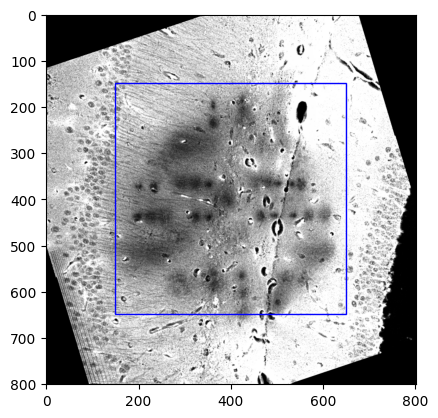

In [5]:
# @title Add OCT view

transformed_center = target_image.shape[0] // 2, target_image.shape[1] // 2

bottom_left_x = transformed_center[0] - oct_size_um // 2
bottom_left_y = transformed_center[1] - oct_size_um // 2

cv.rectangle(transformed_image, (bottom_left_x, bottom_left_y), (bottom_left_x + oct_size_um, bottom_left_y + oct_size_um), (0, 0, 255), 2)
cv.imwrite("transformed_with_oct.png",transformed_image)
files.download("transformed_with_oct.png")

plt.imshow(transformed_image)

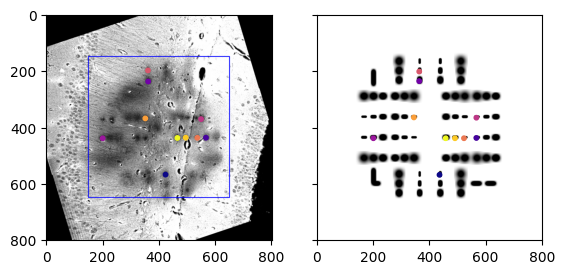

In [6]:
color_indices = np.linspace(0, 1, len(tr_points))

fig,ax = plt.subplots(1,2, sharex=True, sharey=True)
ax[0].imshow(transformed_image)
ax[1].imshow(target_image, cmap='gray')
ax[0].scatter(tr_points[:,0],tr_points[:,1],c=color_indices, cmap='plasma',s=10)
ax[1].scatter(dest_eval[:,0],dest_eval[:,1],c=color_indices, cmap='plasma',s=10)
fig.show()